## Comparison between Lambert Beers Law and Transfer Matrix absorption and their effects in a two temperature model
In this file the absorption calculated with an exponential decay, according to Lambert Beers law and the local absorption evaluated, using the Transfer Matrix Method are being compared within the framework of a two temperature model calculation originally proposed by Anisimov et al. but more recently used by J. Hohlfeld et al. and D. Schick et al. among others.  
The sample case under consideration is : 

| Layer       	    | length    	|  refractive index 	|
|-------------------|--------------	|----------------------	|
| Platinum       	| 3nm layer    	| n = 1.0433 + i3.0855 	|
| Cobalt         	| 15nm layer   	| n = 1.0454 + i3.2169 	|
| Chromium       	| 5nm layer    	| n = 2.0150 + i2.8488 	|
| Magnesium Oxide 	| inf- layer 	| n = 1.7660            |

The procedure of this session is to: 

* Run a local absorption computation to obtain the local absorption profile of the layer (This is just done for reference, in fact the local absorption module is also implemented in the NTMpy package.)

* Run different simulations with the NTMpy, changing the input source from a Lambert Beer description to a Transfer Matrix description  of the absorption.



In [12]:
import sys
sys.path.append("C:/Users/lUKAS/Documents/UDCM/Objects")
import TMM_abs as atmm #Import absorption file (The algorithm here is implemented in the NTMpy package)
from NTMpy import NTMpy as ntm
from matplotlib import pyplot as plt
import numpy as np
import numericalunits as u #Numerical units to show physcal dimensions. (In principle not required)
u.reset_units('SI')

In [13]:
#Define the complex refractive index for every layer and the length of every layer
#layers:  Air   Pt          Co                  Cr          MgO 
n_list = [1, 1.0433+3.0855j,1.0454+3.2169j,2.0150+2.8488j,1.766] 
n_Pt = n_list[1]; n_Co = n_list[2]; n_Cr = n_list[3]
d_list = [np.inf,3,15,5 ,np.inf] #in nm 
th0    = np.pi/4 #in rad. (0 is perpendicular to the surface)
lam0   = 400     # wavelength in vacuum
pol    = 'p'     #polarization

Based on the suggestions made by [Steven J. Byrnes](https://arxiv.org/abs/1603.02720) the total absorption, reflection and transmission $A$, $R$, $T$ are calculated based on the idea of transfer matrices, where the refractive index, the incident angle and the length of every layer are taken into consideration. The parameters $A,R,T$ are normalized with respect to the incident power. 

The results obtained have been compared with [Steven J. Byrnes- Sample 4](https://github.com/sbyrnes321/tmm/blob/master/examples.ipynb) and to results obtained by calculations, executed via COMSOL Multiphysics, where we find that the simulation done in 1D here matches almost exactly with a 2D simulation done with COMSOL Multiphysics where each layer attributes were extended homogeneously on to one more degree of freedom. Hence our 1D model is a good approximation even to a higher dimensional case.

In [14]:
plotpoints                  = 500
[M,M_n,t,r,T,R,A,theta]     = atmm.TM(th0,lam0,n_list,d_list,pol)
[absorp,grid]               = atmm.absorption(th0,lam0,n_list,d_list,pol,plotpoints)

In [15]:
print(f"Total transmission at the end {T:.2}\n"\
      f"Total reflectance at the first layer {R:.2}\n"\
      f"Total Absortpin at the entire material {A:.2}")

Total transmission at the end 0.14
Total reflectance at the first layer 0.51
Total Absortpin at the entire material 0.36


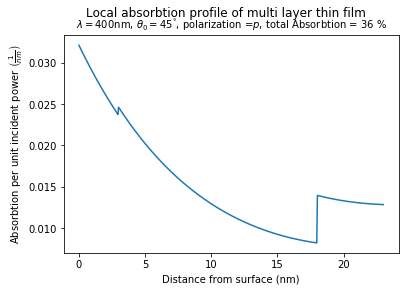

In [16]:
#--> Result obtained by calling the function absorption()
plt.figure()
plt.suptitle('Local absorbtion profile of multi layer thin film', fontsize=12)
plt.title(r"$\lambda=400$nm, $\theta_0=45^°$, polarization =$p$, total Absorbtion = {:.0f} %"\
          .format(np.round(A,2)*100),fontsize=10)
plt.xlabel("Distance from surface (nm)"); 
plt.ylabel(r"Absorbtion per unit incident power $\left(\frac{1}{nm}\right)$")
plt.plot(grid,absorp)
plt.show()

Now we are considering the two-temperature model, where the equation is given below, i.e. two coupled differential equations. Note that the source term $S(x,t)$ is the part which we are going to consider with the two different approaches. Since the deposited energy and therefor also the heating depends mostly on where and how much energy is deposited. 
In addition, one has to mention that we are considering zero flux boundary condition on both sides and an initial temperature of 300K along the entire material. 

That is
\begin{align}
    \begin{cases}
        \partial_x(\varphi(0,t))= \partial_x(\varphi(L,t)) &= 0 &\text{ Neumann boundary condition}\\
        \varphi(x,0) &= 300 K &\text{ initial condition}
    \end{cases}
\end{align}

However, before starting the simulation the variables, given in the coupled heat diffusion equation below have to be expressed. 

\begin{align}
    \begin{cases}
        C_i^E(\varphi^E(x,t))\cdot\rho_i\cdot\partial_t\varphi^E(x,t) &= \partial_x\left(k^E_i(\varphi^E_i(x,t))\cdot \partial_x\varphi^E_i(x,t)\right) + G_i\cdot(\varphi^L_i(x,t)-\varphi^E_i(x,t)) + S(x,t) \\
        C_i^L(\varphi^L(x,t))\cdot\rho_i\cdot\partial_t\varphi^L(x,t) &= \partial_x\left(k^L_i(\varphi^L_i(x,t))\cdot \partial_x\varphi^L_i(x,t)\right) + G_i\cdot(\varphi^E_i(x,t)-\varphi^L_i(x,t))
    \end{cases}
\end{align}

Where $S(x,t)$ is the source applied on the material, $C_i^{E,L}$ and $k_i^{E,L}$ are heat capacity and conductivity for every $i$´th layer with respect to the electron/lattice system, as a generic function of the temperature $\varphi^{E,L}(x,t)$ of the system. The constants $\rho_i$ and $G_i$ describe the density and the electron-lattice coupling for every layer. 


 

In [17]:
#Platinum
length_Pt   = 3*u.nm #Length of the Material
k_el_Pt     = 73*u.W/(u.m*u.K);#Heat conductivity
rho_Pt      = 1e3*21*u.kg/(u.m**3)#Density
C_el_Pt     = lambda Te: (740*u.J/(u.m**3*u.K**2))/(1e3*21*u.kg/(u.m**3)) *Te #Electron heat capacity
C_lat_Pt    = 2.8e6*u.J/(u.m**3*u.K**2)/rho_Pt#Lattice heat capacity
G_Pt        = 1e16*25*u.W/(u.m**3*u.K)        #Lattice electron coupling constant
#Cobalt
length_Co   = 15*u.nm;  
k_el_Co     = 100*u.W/(u.m*u.K);
rho_Co      = 1e3*8.86*u.kg/(u.m**3)
C_el_Co     = lambda Te: (704*u.J/(u.m**3*u.K**2))/(1e3*8.86*u.kg/(u.m**3)) *Te
C_lat_Co    = 4e6*u.J/(u.m**3*u.K**2)/rho_Co
G_Co        = 1e16*93*u.W/(u.m**3*u.K)
#Chromium
length_Cr   = 5*u.nm; 
k_el_Cr     = 95*u.W/(u.m*u.K);
rho_Cr      = 1e3*7.15*u.kg/(u.m**3)
C_el_Cr     = lambda Te: (194*u.J/(u.m**3*u.K**2))/(1e3*7.15*u.kg/(u.m**3)) *Te
C_lat_Cr    = 3.3e6*u.J/(u.m**3*u.K**2)/rho_Cr
G_Cr        = 1e16*42*u.W/(u.m**3*u.K)


In [18]:
# Source
s                           = ntm.source()
s.spaceprofile              = "LB"# We are going to consider the Lambert Beer case first
s.timeprofile               =  "Gaussian"
s.FWHM                      = 0.1*u.ps 
s.fluence                   = 1*u.mJ/u.cm**2
s.t0                        = 0.5*u.ps #Peake of Gaussian
s.lambda_vac                = 400 #in nm

Note that the Lambert Beer "law" is a heuristic one, which can be ralated to the refractive index,by 
\begin{align}
    \alpha &= \frac{4\pi}{\lambda_0}\cdot \operatorname{Im}(n) \\ \nonumber
     I(z)  &= I_0e^{-\alpha z} 
\end{align}
Where the optical penetration depth $\delta_p$ = $\frac{1}{\alpha}$, $\lambda_0$ is the wavelength in vacuum and as indicated $n$ is the refractive index.

In [19]:
#Two temperatures are considered, electron and lattice
sim = ntm.simulation(2,s)
#add parameters for all layers and both systems
#lengt,refractive_index, conductivity [electron, lattice], heatCapacity [electron, lattice], density, linear Coupling 
sim.addLayer(length_Pt,n_Pt,[k_el_Pt,k_el_Pt],[C_el_Pt,C_lat_Pt],rho_Pt,G_Pt) #Platinum 
sim.addLayer(length_Co,n_Co,[k_el_Co,k_el_Co],[C_el_Co,C_lat_Co],rho_Co,G_Co) #Cobalt
sim.addLayer(length_Cr,n_Cr,[k_el_Cr,k_el_Cr],[C_el_Cr,C_lat_Cr],rho_Cr,G_Cr) #Chromium  
sim.final_time = 5*u.ps

------------------------------------------------------------
The simulation object of the 2 temerature system has been passed on to the visual class.
------------------------------------------------------------
-----------------------------------------------------------
 No specific time constant has been indicated. 
 The stability region has been calculated and an appropriate timestep has been chosen.
 Timestep = 2.67e-17 s
-----------------------------------------------------------
-----------------------------------------------------------
Lambert Beer´s absorption law and a Gaussian time profile is applied as source.
-----------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████| 187480/187480 [01:36<00:00, 1939.92it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-lattice system has been simulated
Eleapsed time in E.E.- loop: 96.65876913070679
-----------------------------------------------------------
-----------------------------------------------------------
Lambert Beer´s absorption law and a Gaussian time profile is applied as source.
-----------------------------------------------------------


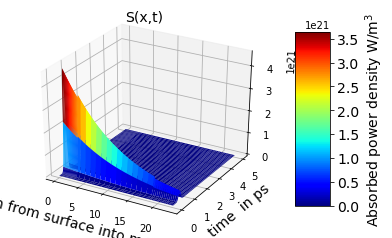

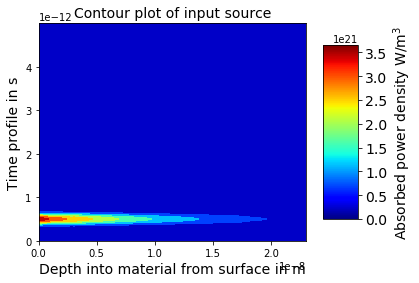

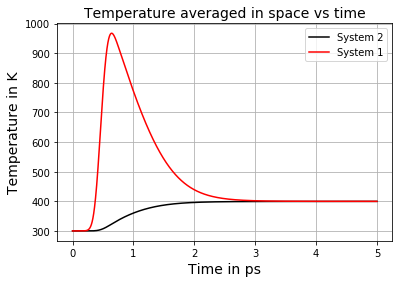

(2, 187481)


In [20]:
v = ntm.visual(sim)
#output of v.source is the full matrix of the source(x,t)
so               = v.source() 
[tt,avTemp]      = v.average()#Averaged in space 
print(avTemp.shape)

In the first picture we can see a surface and in the second a contour plot of the source that has been applied to the system. We see that the optical penetration depth of Platinum is very similar to the one of Cobalt and Chromium, that is their imaginary part of the refractive index is very much alike, which is why the transition appears between the different layers appears almost to be smooth.

What we can do now, in order to make our calculation of the deposited energy in the system more accurate, is to multiply the amplitude of the source times $A$, that is the amount of energy absorbed. Now we are considering some results obtained by the transfer matrix formalism, but not the entire local absorption profile. 
Changing the parameters and recalculation leads to: 

------------------------------------------------------------
The simulation object of the 2 temerature system has been passed on to the visual class.
------------------------------------------------------------
-----------------------------------------------------------
 No specific time constant has been indicated. 
 The stability region has been calculated and an appropriate timestep has been chosen.
 Timestep = 2.67e-17 s
-----------------------------------------------------------
-----------------------------------------------------------
Lambert Beer´s absorption law and a Gaussian time profile is applied as source.
-----------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████| 187480/187480 [01:17<00:00, 2410.97it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-lattice system has been simulated
Eleapsed time in E.E.- loop: 77.76114988327026
-----------------------------------------------------------
-----------------------------------------------------------
Lambert Beer´s absorption law and a Gaussian time profile is applied as source.
-----------------------------------------------------------


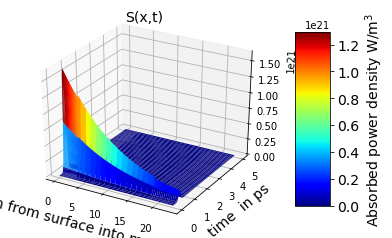

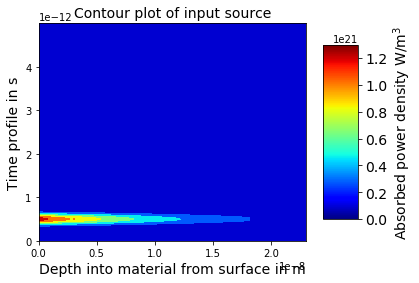

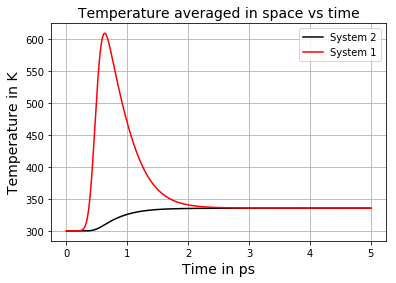

In [21]:
oldfluence     = s.fluence
#Here the coefficient of the absorbed amount has been added
s.fluence      = oldfluence*A 
#Pass on the source with the modified incident fluence and simulate again
sim            = ntm.simulation(2,s)
sim.addLayer(length_Pt,n_Pt,[k_el_Pt,k_el_Pt],[C_el_Pt,C_lat_Pt],rho_Pt,G_Pt) #Platinum 
sim.addLayer(length_Co,n_Co,[k_el_Co,k_el_Co],[C_el_Co,C_lat_Co],rho_Co,G_Co) #Cobalt
sim.addLayer(length_Cr,n_Cr,[k_el_Cr,k_el_Cr],[C_el_Cr,C_lat_Cr],rho_Cr,G_Cr) #Chromium  
sim.final_time = 5*u.ps
#Visualize result
v              = ntm.visual(sim)
so             = v.source() 
[tt,avT]       = v.average()

Comparing this output now to what we we were seeing before, we can clearly see that the temperature is way lower than before. This is since we are considering that not all the incident power is deposited in the material but some of it is back reflected.
Note however, that the shape of the pulse heating the material is the same!

Let us look at the full heat map via a contour plot to also see which areas in space get heated up.

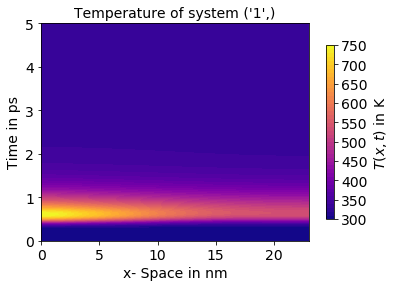

In [22]:
#Input is a string corresponding to the system under consideration
v.contour('1') #Electron system

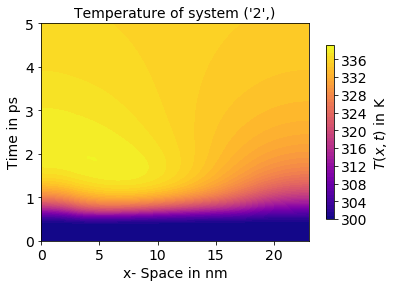

In [23]:
v.contour('2') #Lattice system

Now we will switch from the Lambert Beer law, which takes the optical penetration depth of every material into consideration to the Transfer matrix method to calculate the local absorption at every grid point, as shown above. 

The only thing that has to be changed in the code is the spaceprofile type (from `"LB"` to `"TMM"`). 
Some additional input parameters also have to be given, i.e. `polarization = "s"` or `"p"`. 
And the incident angle `s.theta_in = number` a float number.

------------------------------------------------------------
The simulation object of the 2 temerature system has been passed on to the visual class.
------------------------------------------------------------
-----------------------------------------------------------
 No specific time constant has been indicated. 
 The stability region has been calculated and an appropriate timestep has been chosen.
 Timestep = 2.67e-17 s
-----------------------------------------------------------
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-----------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████| 187480/187480 [01:25<00:00, 2205.36it/s]


-----------------------------------------------------------
Heat diffusion in a coupled electron-lattice system has been simulated
Eleapsed time in E.E.- loop: 85.01106071472168
-----------------------------------------------------------
-----------------------------------------------------------
Transfer matrix absorption profile and a Gaussian time profile is taken into account for the source.
Length of every layer has to be given in units of meter.
-----------------------------------------------------------


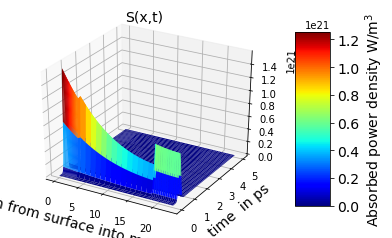

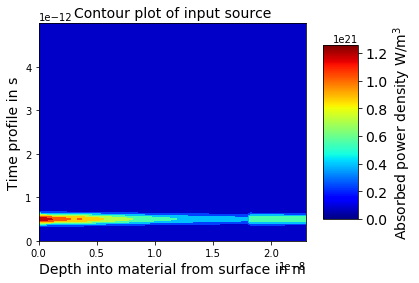

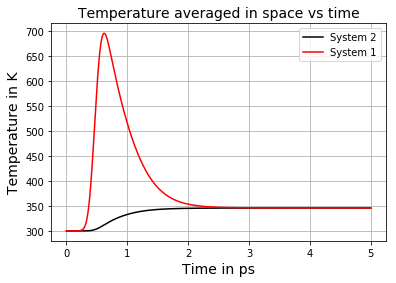

In [25]:
#Transfer matrix method is now considered
s                           = ntm.source()
s.spaceprofile              =  "TMM" #Change to Transfer Matrix Method
s.FWHM                      = 0.1*u.ps 
s.fluence                   = 1*u.mJ/u.cm**2
s.t0                        = 0.5*u.ps
s.lambda_vac                = lam0
#provide additional input for the TM method, as indicated above
s.theta_in                  = th0
s.polarization              = pol

sim = ntm.simulation(2,s)
sim.addLayer(length_Pt,n_Pt,[k_el_Pt,k_el_Pt],[C_el_Pt,C_lat_Pt],rho_Pt,G_Pt) #Platinum 
sim.addLayer(length_Co,n_Co,[k_el_Co,k_el_Co],[C_el_Co,C_lat_Co],rho_Co,G_Co) #Cobalt
sim.addLayer(length_Cr,n_Cr,[k_el_Cr,k_el_Cr],[C_el_Cr,C_lat_Cr],rho_Cr,G_Cr) #Chromium  
sim.final_time = 5*u.ps

v                = ntm.visual(sim)
so               = v.source() 
[tt,avTemp] = v.average()

Since now we also take reflections within the material into consideration, the average temperature is higher. Most of all we see that the shape of the source is different.

We can see lots of absorption on and close to the surface of the material. On the other hand, we can also see an absorption peak at the very end. This can be explained through the appearing reflections within the layer, that occure on the Chromium- MgO- edge (recall our stack structure from the table above).

The dynamics can also be depicted in a not averaged form, that is by showing the contour plots of time and space dynamics for each system, lattice and electrons, separately. 

Comparing the contour plots with respect to Lambert Beer and TMM heating, one could not only see a difference in the average temperature but also which points in space have been over/ underestimated.

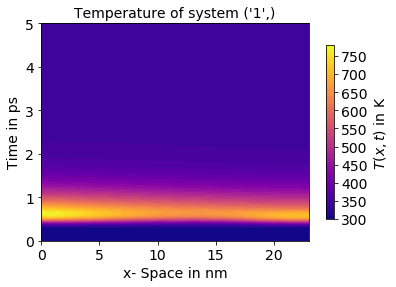

In [26]:
#Input is a string corresponding to the system under consideration
v.contour('1') #Electron system

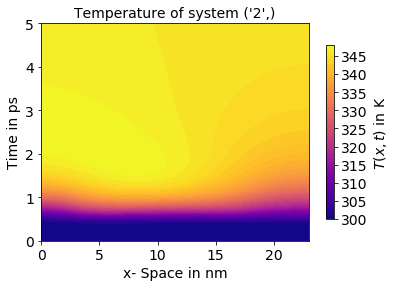

In [27]:
v.contour('2') #lattice system

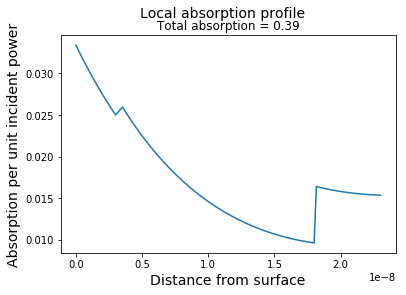

In [28]:
#Same plot as in the beginning of the session just integrated as a method in the visual class
[T,R,A,absorption,xflat,grid] = v.localAbsorption()

Summarizing we find the TMM matrix the best method and recommend it to the user if they are interested in finding a precise description of local absorption of energy, which is in the zero-flux boundary case the most important factor of heating a material. Also, different incident angles and polarization can be considered, which makes this representation a more realistic approach to physical experiments.

However, in order to get quick results and for pedagogical reasons/ consistency checks on can also use the Lambert Beer spacial profile. Keep in mind though that one most likely overshoots the energy deposit.

Since for some configuration the time step for integrating the coupled differential equation must be chosen very small, the amount of produced data can be huge. Therefore we integrated an algorithm, that uses _block averaging_, i.e. statistics in order to compress the obtained data. We can, in this case, lower the amount of data obtained from almost 2 million-time-steps (in the case above) to only a few hundred data points, still giving us a reliable result.

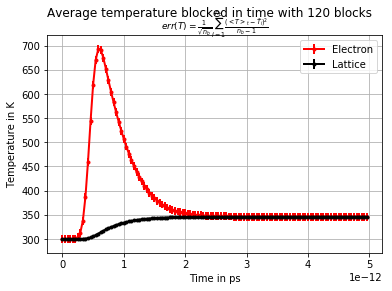

In [29]:
blocks = 120 #number of points in the time grid
#Apply the blocking method to both, electron and lattice system
[blockvecE,blocktt, errorE , sigmaE] = v.blocking(avTemp[0],tt,blocks)
[blockvecL,blocktt, errorL , sigmaL] = v.blocking(avTemp[1],tt,blocks)
#Depict the data
plt.figure()
plt.suptitle(f"Average temperature blocked in time with {blocks} blocks",fontsize = 12)
plt.title(r"$err(T) = \frac{1}{\sqrt{n_b}}\sum_{i=1}^{n_b}\frac{(<T>_t-\bar{T}_i)^2}{n_b-1}$",fontsize = 9)
plt.xlabel("Time in ps"); plt.ylabel("Temperature in K")
plt.grid()
plt.errorbar(blocktt,blockvecE,yerr=errorE,ms = 3,fmt='r-o',linewidth=2,label = "Electron")
plt.errorbar(blocktt,blockvecL,yerr=errorL,ms = 3,fmt='k-o',linewidth=2,label = "Lattice")
plt.legend()
plt.show()